# Initialise 

default_parameters -> fit

default_limit -> physical

parameters -> physical

In [4]:
import datetime
from IPython.display import display
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

%matplotlib inline

mem = joblib.Memory(location='/ssd/rulands/fabian_tmp/non-hepato', verbose=0)

import logging

# logging.basicConfig(filename='c14.log',
#                             filemode='a',
#                             format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
#                             datefmt='%H:%M:%S',
#                             level=logging.INFO)

In [5]:
# %load_ext autoreload
# %autoreload 2
import c14
import c14.models.liver_nonhepato

In [13]:
data = pd.read_csv('../../../results/C14data_liver_samples_20200129.csv')
data = data.groupby(['type', 'sample', 'ploidy', 'pathology']).mean().dropna(how='all').reset_index()
data['age'] = data['Dcoll'] - data['Dbirth']
data = data.query('type == "non-hepatocyte" and pathology != "Y"')
edata = c14.exp_data(data)

In [7]:
@mem.cache
def fit_model(edata, model, step_size=0.1, optimize_minuit_multistart_kwargs=dict(n=100,processes=8)):
    print(f'Fitting model {model.__name__}')
    result = {'model': model()}
    result['op'] = c14.optimize(model=result['model'],data=edata,step_size=step_size)
    result['vis'] = c14.visualisze(model=result['model'],data=edata,step_size=2)
    result['multistart_result'] = result['op'].optimize_minuit_multistart(**optimize_minuit_multistart_kwargs)
    try:
        result['point_estimate'] = result['multistart_result'].sort_values('fval').iloc[0]['values']
        result['cov'] = result['multistart_result'].sort_values('fval').iloc[0]['cov']
    except:
        print(f'Multistart found no valid results for model {model.__name__}')
    try:
        result['errors'] = result['vis'].calc_error(result['point_estimate'], result['cov'])
    except:
        print(f'Could not calculate errors for {model.__name__}')
    return result

In [8]:
def fit_models(edata, models, step_size=0.1, optimize_minuit_multistart_kwargs=dict(n=100,processes=8)):
    results = {model.__name__: fit_model(edata, model, step_size, optimize_minuit_multistart_kwargs)
               for model in models}
    return results

In [9]:
models = c14.models.liver_nonhepato.models_list
models

[c14.models.minimal.POP1,
 c14.models.minimal.POP1q,
 c14.models.liver_nonhepato.POP2]

In [10]:
init_limit = {'lambda_': (-3, 0), 
              'lambda1': (-3, 0),
              'lambda2': (-3, 0),
              'f': (-3, 3)
             }

In [12]:
%%time
results = fit_models(edata, models, step_size=2, 
                     optimize_minuit_multistart_kwargs=dict(n=7, 
                                                            processes=7, 
                                                            init_limit=init_limit)
                    )

Fitting model POP1
[(-3, 0)]
Fitting model POP1q
[(-3, 3), (-3, 0)]


/home/fabrost/pksCloud/projects/c14/source/c14/c14/models/minimal.py:89: RuntimeWarning: divide by zero encountered in arctanh
  p_fit['f'] = -np.arctanh(1 - 2*p_phy['f'])
/home/fabrost/pksCloud/projects/c14/source/c14/c14/models/minimal.py:89: RuntimeWarning: invalid value encountered in arctanh
  p_fit['f'] = -np.arctanh(1 - 2*p_phy['f'])
/home/fabrost/pksCloud/projects/c14/source/c14/c14/models/minimal.py:81: RuntimeWarning: overflow encountered in double_scalars
  p_phy[p] = 10**p_fit[p]
/home/fabrost/pksCloud/projects/c14/source/c14/c14/models/minimal.py:81: RuntimeWarning: overflow encountered in double_scalars
  p_phy[p] = 10**p_fit[p]


Fitting model POP2
[(-3, 3), (-3, 0), (-3, 0)]


/home/fabrost/miniconda3/envs/spols200116/lib/python3.7/site-packages/scipy/optimize/optimize.py:697: RuntimeWarning: invalid value encountered in double_scalars
  df = (f(*((xk + d,) + args)) - f0) / d[k]


CPU times: user 495 ms, sys: 154 ms, total: 649 ms
Wall time: 11.7 s


In [9]:
%%time
results = fit_models(edata, models, step_size=0.5, 
                     optimize_minuit_multistart_kwargs=dict(n=100, 
                                                            processes=7, 
                                                            init_limit=init_limit)
                    )

CPU times: user 376 ms, sys: 5.31 ms, total: 381 ms
Wall time: 387 ms


POP1


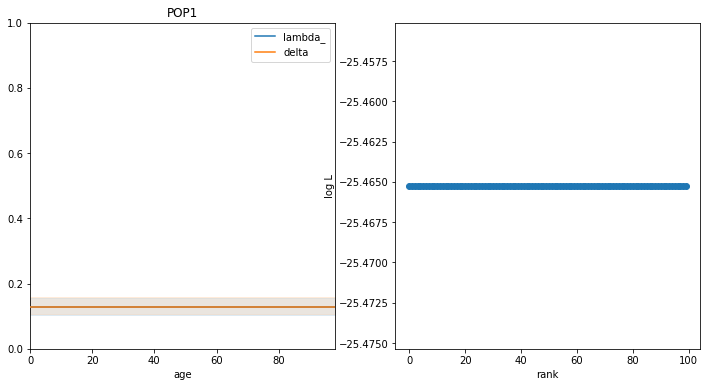

point_estimate     lower     upper
time parameter                                   
0    delta           0.128431   0.10434  0.157548
     lambda_         0.128431  0.104905  0.157233
80   delta           0.128431   0.10434  0.157548
     lambda_         0.128431  0.104905  0.157233

POP1q


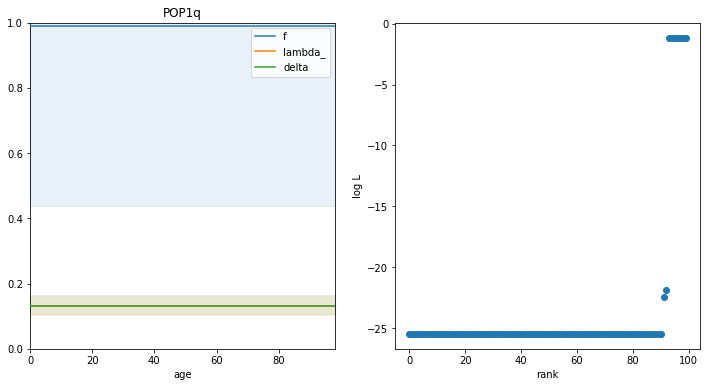

point_estimate     lower     upper
time parameter                                   
0    delta           0.130831  0.103406  0.161266
     f               0.990418  0.437767  0.999927
     lambda_         0.130831  0.104974  0.163055
80   delta           0.130831  0.103406  0.161266
     f               0.990418  0.437767  0.999927
     lambda_         0.130831  0.104974  0.163055

POP2


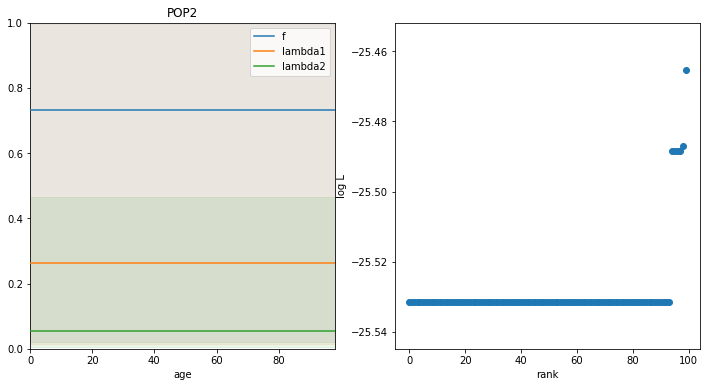

point_estimate       lower     upper
time parameter                                     
0    f               0.732317    0.021042  0.997136
     lambda1         0.264547   0.0137801   5.07869
     lambda2        0.0548792  0.00648173  0.464649
80   f               0.732317    0.021042  0.997136
     lambda1         0.264547   0.0137801   5.07869
     lambda2        0.0548792  0.00648173  0.464649

In [10]:
for name, result in results.items():
    print(name)
    fig, axs = plt.subplots(1, 2, figsize=(12,6))
    result['vis'].plot_parameter(result['point_estimate'], result['errors'], no_plot=[], axis=axs[0])
    axs[0].legend()
    axs[0].set_title(name)
    axs[0].set_ylim(0,1)
    
    fval = result['multistart_result']['fval']
    axs[1].scatter(np.arange(len(fval)), fval.values)
    axs[1].set_xlabel('rank')
    axs[1].set_ylabel('log L')
    
    plt.show()
   
    display(result['vis'].get_parameter(result['point_estimate'], result['cov'], t_eval=[0, 80]))

In [11]:
final_results = pd.DataFrame(pd.Series({name: result['op'].calc_aicc(result['point_estimate']) for name, result in results.items()}, name='cAIC'))
final_results['loglike'] = [result['op'].loglike_dict(result['point_estimate']) for model, result in results.items()]
final_results['nparas'] = [result['model'].nparas for model, result in results.items()]
final_results = pd.DataFrame(final_results)
final_results['delta'] = final_results['cAIC'] - final_results['cAIC'].min() 
final_results['w'] = np.exp(-0.5*final_results['delta']) / np.exp(-0.5*final_results['delta']).sum()
final_results['ER'] = final_results['w'].max() / final_results['w']
final_results.sort_values('cAIC')

,cAIC,loglike,nparas,delta,w,ER
POP1,-45.730476,25.465238,1,0.000000,0.831889,1.000000
POP1q,-42.305945,25.486306,2,3.424531,0.150120,5.541501
POP2,-38.062884,25.531442,3,7.667592,0.017992,46.237728
